In [1]:
import torch
import numpy as np
from model import Model
from normalizer import Normalizer
from plotter import Plotter
from backup_manager import BackupManager

In [2]:
max_files = 10

In [3]:
files = BackupManager.detect_files("data/main")[:max_files]
raw_data, raw_parameters, _ = BackupManager.load_data(files)
n_samples = raw_data.shape[0]
n_points = raw_data.shape[1]

Loading files:   0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
print("Raw data")
print(raw_data.shape)
print(raw_data[0,:10])
unique_points, counts = torch.unique(
    raw_data[0],
    dim=0,
    return_counts=True
)
print("#unique points", unique_points.shape[0])

print("\nRaw parameters")
print(raw_parameters.shape)
print(raw_parameters[:10])

Raw data
torch.Size([5000, 1000, 4])
tensor([[ 7.9527,  0.4014,  0.4317,  2.3912],
        [ 7.9527,  0.4014,  0.4317,  2.3912],
        [ 7.3832, -0.1487,  0.5121,  0.8268],
        [ 7.3832, -0.1487,  0.5121,  0.8268],
        [ 7.6110,  0.6507,  0.9793,  0.3819],
        [ 6.7614,  0.5939,  0.0826, -1.4461],
        [ 7.7997,  0.9519,  0.7251, -1.5234],
        [ 7.7997,  0.9519,  0.7251, -1.5234],
        [ 6.7991, -0.2088,  0.8092, -0.6216],
        [ 6.7991, -0.2088,  0.8092, -0.6216]])
#unique points 540

Raw parameters
torch.Size([5000, 1])
tensor([[3.5020],
        [3.4878],
        [4.7986],
        [4.1512],
        [4.4888],
        [3.3989],
        [4.2558],
        [4.0278],
        [4.7337],
        [4.2062]])


In [5]:
normalizer = Normalizer.create_normalizer(raw_data)
data = normalizer.normalize_data(raw_data)
parameters = normalizer.normalize_parameters(raw_parameters)

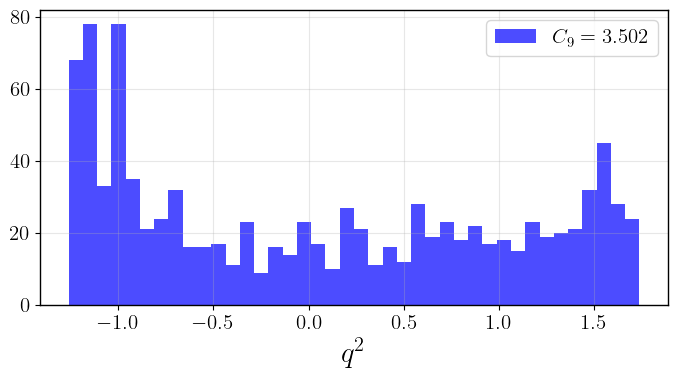

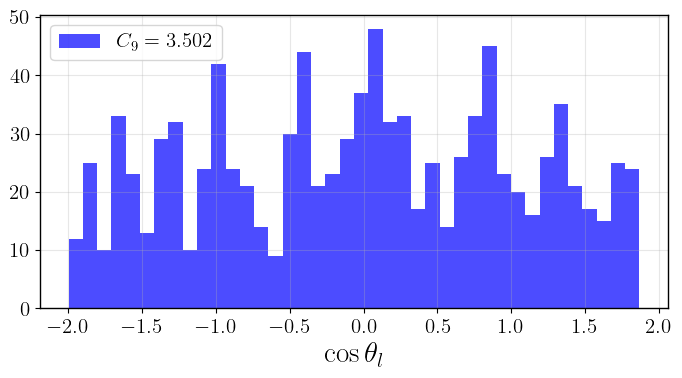

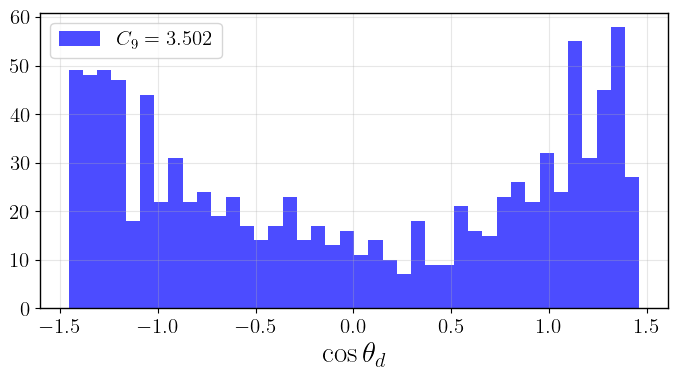

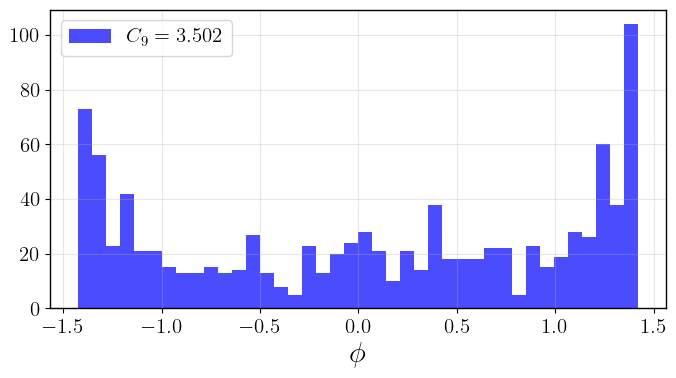

In [6]:
Plotter.plot_a_sample(data[0], parameters[0])

In [7]:
# Analyse statistique : moyennes et écarts-types pour chaque observable
# Sélectionner quelques échantillons avec différentes valeurs de C_9

# Trier par valeur de C_9
sorted_indices = torch.argsort(raw_parameters.squeeze())
n_compare = 5  # Nombre d'échantillons à comparer

# Sélectionner des échantillons espacés (min, 25%, 50%, 75%, max)
indices_to_compare = sorted_indices[torch.linspace(0, len(sorted_indices)-1, n_compare).long()]

print("=" * 80)
print("COMPARAISON DES STATISTIQUES POUR DIFFÉRENTES VALEURS DE C_9")
print("=" * 80)

observable_names = ["q²", "cos(θ_l)", "cos(θ_d)", "φ"]

for idx in indices_to_compare:
    sample = raw_data[idx]
    param = raw_parameters[idx]
    
    print(f"\n{'─' * 80}")
    print(f"C_9 = {param.item():.4f}")
    print(f"{'─' * 80}")
    print(f"{'Observable':<15} {'Mean':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
    print(f"{'─' * 80}")
    
    for i, obs_name in enumerate(observable_names):
        obs_data = sample[:, i]
        print(f"{obs_name:<15} {obs_data.mean():.4f}{'':<10} "
              f"{obs_data.std():.4f}{'':<10} "
              f"{obs_data.min():.4f}{'':<10} "
              f"{obs_data.max():.4f}{'':<10}")

print(f"\n{'=' * 80}")
print("RÉSUMÉ : Vérification de la variabilité entre échantillons")
print(f"{'=' * 80}")

# Calculer les moyennes pour tous les échantillons
all_means = raw_data.mean(dim=1)  # [n_samples, 4]

for i, obs_name in enumerate(observable_names):
    means_for_obs = all_means[:, i]
    print(f"\n{obs_name}:")
    print(f"  - Moyenne des moyennes : {means_for_obs.mean():.4f}")
    print(f"  - Écart-type des moyennes : {means_for_obs.std():.4f}")
    print(f"  - Min des moyennes : {means_for_obs.min():.4f}")
    print(f"  - Max des moyennes : {means_for_obs.max():.4f}")
    print(f"  => Variabilité = {means_for_obs.std():.4f} (devrait être > 0 si C_9 a un effet)")

COMPARAISON DES STATISTIQUES POUR DIFFÉRENTES VALEURS DE C_9

────────────────────────────────────────────────────────────────────────────────
C_9 = 3.0002
────────────────────────────────────────────────────────────────────────────────
Observable      Mean            Std             Min             Max            
────────────────────────────────────────────────────────────────────────────────
q²              4.0214           2.3273           1.0152           7.9842          
cos(θ_l)        0.0194           0.5317           -0.9986           0.9993          
cos(θ_d)        0.1062           0.6656           -0.9994           0.9974          
φ               0.0076           1.7838           -3.1234           3.1247          

────────────────────────────────────────────────────────────────────────────────
C_9 = 3.4888
────────────────────────────────────────────────────────────────────────────────
Observable      Mean            Std             Min             Max            
───────


Génération des graphiques de comparaison...


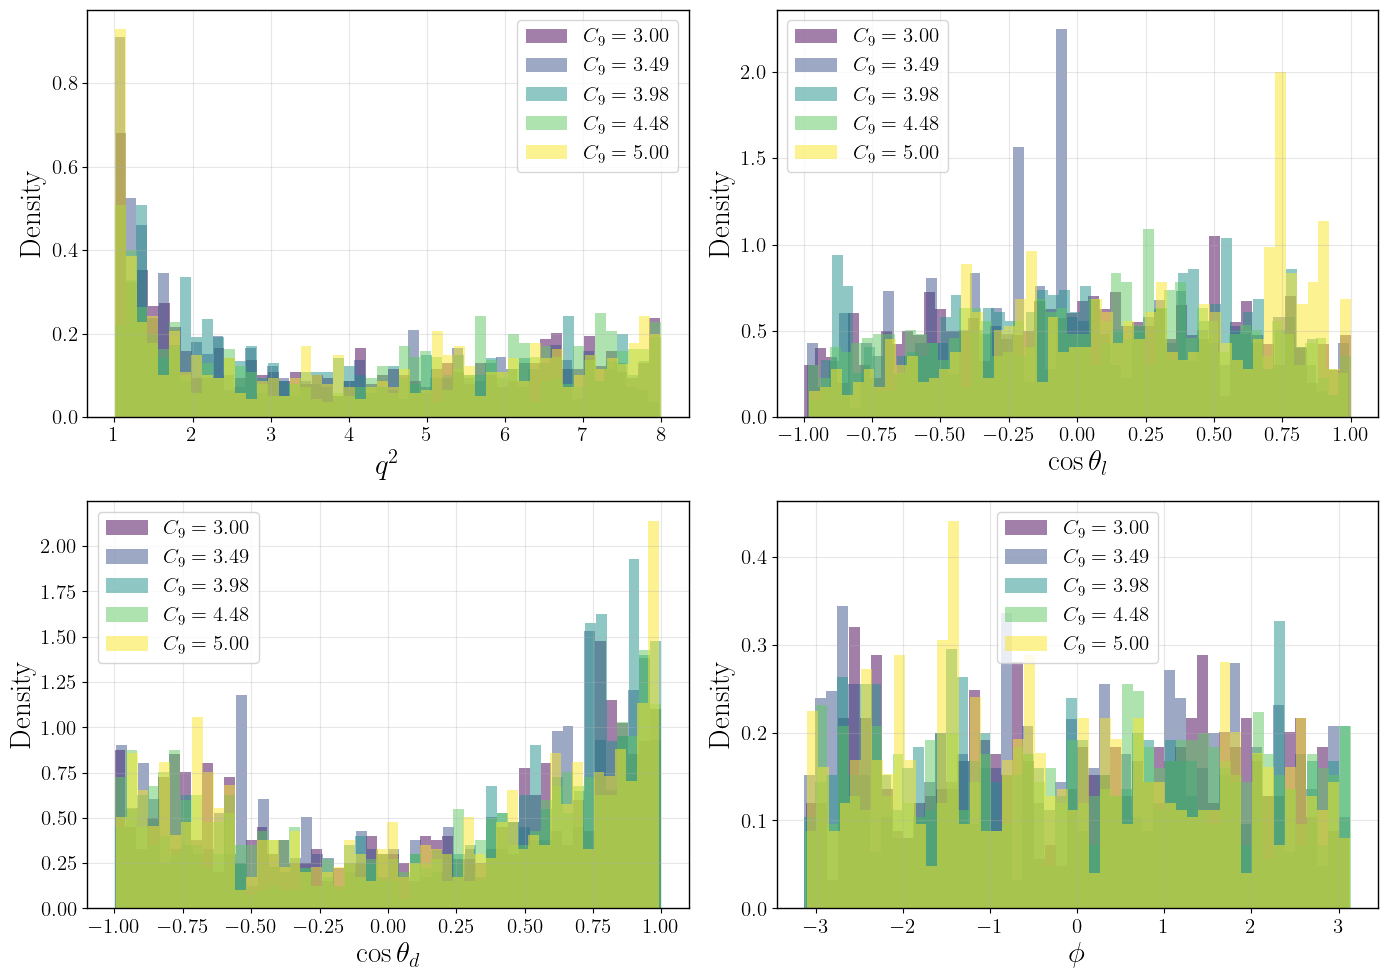

In [8]:
# Visualisation : comparer les distributions pour différentes valeurs de C_9
print("\nGénération des graphiques de comparaison...")
Plotter.compare_distributions(raw_data, raw_parameters, n_samples_to_plot=5)

In [9]:
# Test de corrélation : vérifier si C_9 influence les distributions
# Calculer la corrélation entre C_9 et les moyennes de chaque observable

print("\n" + "=" * 80)
print("CORRÉLATION ENTRE C_9 ET LES OBSERVABLES")
print("=" * 80)

# Calculer les moyennes et écarts-types pour tous les échantillons
all_means = raw_data.mean(dim=1)  # [n_samples, 4]
all_stds = raw_data.std(dim=1)    # [n_samples, 4]

c9_values = raw_parameters.squeeze().cpu().numpy()

print("\nCorrélation entre C_9 et la MOYENNE de chaque observable:")
print(f"{'Observable':<15} {'Corrélation':<15} {'Interprétation':<30}")
print("─" * 80)

for i, obs_name in enumerate(observable_names):
    means = all_means[:, i].cpu().numpy()
    correlation = np.corrcoef(c9_values, means)[0, 1]
    
    if abs(correlation) > 0.5:
        interpretation = "FORTE dépendance"
    elif abs(correlation) > 0.2:
        interpretation = "Dépendance modérée"
    else:
        interpretation = "Faible dépendance"
    
    print(f"{obs_name:<15} {correlation:>+.4f}{'':<10} {interpretation:<30}")

print("\nCorrélation entre C_9 et l'ÉCART-TYPE de chaque observable:")
print(f"{'Observable':<15} {'Corrélation':<15} {'Interprétation':<30}")
print("─" * 80)

for i, obs_name in enumerate(observable_names):
    stds = all_stds[:, i].cpu().numpy()
    correlation = np.corrcoef(c9_values, stds)[0, 1]
    
    if abs(correlation) > 0.5:
        interpretation = "FORTE dépendance"
    elif abs(correlation) > 0.2:
        interpretation = "Dépendance modérée"
    else:
        interpretation = "Faible dépendance"
    
    print(f"{obs_name:<15} {correlation:>+.4f}{'':<10} {interpretation:<30}")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("Si les corrélations sont proches de 0, C_9 n'a PAS d'effet sur les distributions.")
print("Si les corrélations sont significatives (> 0.2 en valeur absolue), C_9 INFLUENCE les distributions.")
print("=" * 80)


CORRÉLATION ENTRE C_9 ET LES OBSERVABLES

Corrélation entre C_9 et la MOYENNE de chaque observable:
Observable      Corrélation     Interprétation                
────────────────────────────────────────────────────────────────────────────────
q²              +0.5690           FORTE dépendance              
cos(θ_l)        +0.5517           FORTE dépendance              
cos(θ_d)        -0.0000           Faible dépendance             
φ               -0.0024           Faible dépendance             

Corrélation entre C_9 et l'ÉCART-TYPE de chaque observable:
Observable      Corrélation     Interprétation                
────────────────────────────────────────────────────────────────────────────────
q²              +0.2565           Dépendance modérée            
cos(θ_l)        +0.0092           Faible dépendance             
cos(θ_d)        -0.1522           Faible dépendance             
φ               +0.0049           Faible dépendance             

CONCLUSION:
Si les corrélatio